In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import gaussian_kde as GKDE

from scipy.stats import multivariate_normal
from scipy.stats import norm

import weightedCDFs as wCDFs

import weights

import random

import matplotlib.patches as patches

import seaborn as sns
import matplotlib.colors as colors

import matplotlib as mpl

In [2]:
mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5


CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

In [3]:
rerun_densities = False
rerun_distributions = True

## Problem setup

In [4]:
random.seed(10)

In [5]:
l = 2.
kappa = 1.

In [6]:
N = 100  # Specify the truncation
ts = [1e-4, 1e-2, 1e-1, 0.4, 0.8]
x = np.linspace(0, l, 2*N)

In [7]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

In [8]:
t = .01
sensor_loc = 1.2

In [9]:
def rejection_sampling(r):
    
    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)
    
    return (unifs < (r / M))

## Convergence analysis

In [10]:
low_x = 2.01
upp_x = 2.02
low_y = 0.95
upp_y = 1.0

upp_B = u(N, sensor_loc, t, low_x, low_y)
low_B = u(N, sensor_loc, t, upp_x, upp_y)

delta_l = 0.1
delta_kappa = 0.5

print(f'Upper of B = {upp_B}')
print(f'Lower of B = {low_B}')

Upper of B = 0.5935544013268559
Lower of B = 0.5899603114552461


In [11]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, t, XX[count,:], YY[count,:])

In [12]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 50000
obs_samples = obs_dist.rvs(n_obs_samples)

d_min = np.min(ZZ)
d_max = np.max(ZZ)

print(d_min)
print(d_max)

obs_KDE = GKDE(obs_samples)

0.5766339652753646
0.6136972780535532


In [13]:
n_init_samples = 100000
n_density_trials = 100

In [14]:
if rerun_densities:

    true_up_prob_set = []
    for trial in range(n_density_trials):

        print(f'working on trial {trial}')

        init_samples = np.random.uniform(0, 1, (n_init_samples, 2))
        init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
        init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

        pred_samples = np.zeros((n_init_samples, 1))
        pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
        pred_KDE = GKDE(pred_samples[:,0])

        r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
        rn_w = r / n_init_samples

        true_up_prob_set.append(0)
        for i, isamp in enumerate(init_samples):
            if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                true_up_prob_set[int(trial)] += rn_w[i]
                
    np.save('./data/convergence_dens_prob_A.npy', np.array(true_up_prob_set))

else:

    init_samples = np.random.uniform(0, 1, (n_init_samples,2))
    init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
    init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

    pred_samples = np.zeros((n_init_samples, 1))
    pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    pred_KDE = GKDE(pred_samples[:,0])

    r = obs_KDE(pred_samples[:,0].T) / pred_KDE(pred_samples[:,0].T)
    rn_w = r / n_init_samples

    true_up_prob_set = np.load('./data/convergence_dens_prob_A.npy')

obs_prob_set = obs_dist.cdf(upp_B) - obs_dist.cdf(low_B)

print(np.std(true_up_prob_set))
print(np.mean(true_up_prob_set))

true_up_prob_set = np.mean(true_up_prob_set)

0.0014161128487837397
0.019901640774951327


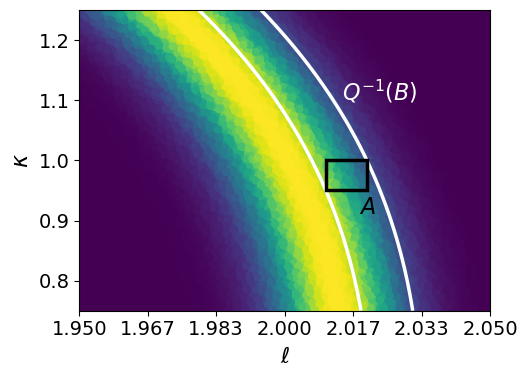

In [15]:
ax = plt.gca()

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.contour(XX, YY, ZZ, levels=[low_B, upp_B], colors=['w', 'w']);

set_A = patches.Rectangle((low_x, low_y), upp_x-low_x, upp_y-low_y, color='k',
                          fill=None, zorder=10, linewidth=2.5)
ax.add_patch(set_A)

plt.text(upp_x-0.002, low_y-0.04, r'$A$', fontsize=16)
plt.text(upp_x-0.006, upp_y+0.1, r'$Q^{-1}(B)$', fontsize=16, color='w')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 7)])

plt.tight_layout()
# plt.savefig('/Users/kirana/Desktop/work/paper/sets_Lambda.png', bbox_inches='tight')

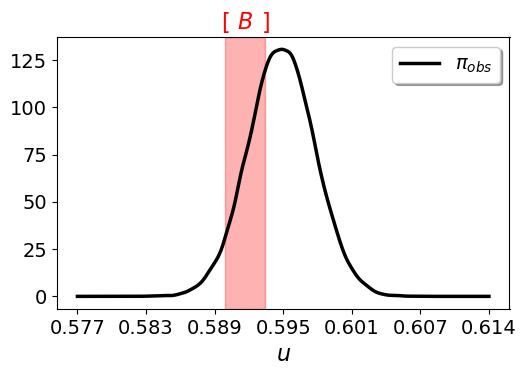

In [16]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)
plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$', color='k')
plt.yticks(fontsize=14)
plt.text((upp_B-low_B)/2 + low_B, 145, r'$B$', color='r', fontsize=16,
         horizontalalignment='center', verticalalignment='center')
plt.text(low_B, 145, r'$[$', color='r', fontsize=16, horizontalalignment='center', verticalalignment='center')
plt.text(upp_B, 145, r'$]$', color='r', fontsize=16, horizontalalignment='center', verticalalignment='center')
plt.axvspan(low_B, upp_B, alpha=0.3, color='r')

plt.legend(loc='upper right', shadow=True)
plt.xlabel(r'$u$')
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)], color='k')

plt.tight_layout()
# plt.savefig('/Users/kirana/Desktop/work/paper/sets_D.png', bbox_inches='tight')

In [113]:
bin_numbers = [20,  40,   60, 80,  100,  120,  140, 160]
# bin_numbers = [20, 40, 60, 80, 100]
# sampling_samples_numbers = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
# sampling_samples_numbers = [1000, 2000, 3000, 4000, 5000, 6000]
sampling_samples_numbers = [1000, 2000, 3000, 4000, 5000]
# sampling_samples_numbers = [1000, 2000, 3000, ]
# sampling_samples_numbers = [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000]

In [114]:
comp_prob_A = []
comp_prob_B = []
count_A = []
count_B = []
centers_B = []

sampling_samples_full = np.random.uniform(0, 1, (sampling_samples_numbers[-1],2))

for i, n_sampling_samples in enumerate(sampling_samples_numbers):

    print(f'working on n = {n_sampling_samples}')

    comp_prob_A.append([])
    comp_prob_B.append([])

    sampling_samples = np.random.normal(0, 1, (n_sampling_samples, 2))
    sampling_samples[:,1] = np.random.beta(2, 5, (n_sampling_samples)) * 2 + 0.5
    sampling_samples[:,0] = sampling_samples[:,0] * delta_l + l

    inds_where_outside = sampling_samples[:,1] > 
    n_outside = np.sum

    pred_samples = np.zeros((n_sampling_samples, 1))
    pred_samples[:, 0] = u(N, sensor_loc, t, sampling_samples[:,0], sampling_samples[:,1])
    
    for b, n_bins in enumerate(bin_numbers):
        
        print(f'working on p = {n_bins}')
        
        w, bins, centers, w_center = weights.computePartitionedWeights_regulargrid_nonIID(sampling_samples,
                                                                        pred_samples,
                                                                        init_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

        weight_set = 0
        count_in_B = 0
        for count, psamp in enumerate(pred_samples): 
            if psamp >= low_B and psamp <= upp_B:
                weight_set += w[count]
                count_in_B += 1
        
        up_prob_set = 0
        count_in_A = 0
        for count, isamp in enumerate(sampling_samples):
            if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                count_in_A += 1 
                up_prob_set += w[count]

        comp_prob_B[i].append(weight_set)
        comp_prob_A[i].append(up_prob_set)

    count_B.append(count_in_B)
    count_A.append(count_in_A)

SyntaxError: invalid syntax (3777260641.py, line 20)

In [115]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for count, b in enumerate(comp_prob_B):
    row_string = f'{sampling_samples_numbers[count]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of B = {obs_prob_set:.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.24465  0.25093  0.25714  0.25826  0.26194  0.26121  0.27652  0.27195  
 2000   0.24972  0.25726  0.25808  0.27681  0.27179  0.27162  0.28247  0.27688  
 3000   0.25263  0.26387  0.25677  0.27224  0.26786  0.26641  0.26942  0.27256  
 4000   0.24853  0.26029  0.25375  0.26653  0.26397  0.26301  0.26262  0.26697  
 5000   0.26320  0.26371  0.25929  0.27170  0.26590  0.26368  0.26568  0.27124  


IndexError: list index out of range

In [116]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for count, b in enumerate(comp_prob_B):
    row_string = f'{sampling_samples_numbers[count]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{np.abs(i-obs_prob_set):.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of B = {obs_prob_set:0.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.02381  0.01753  0.01132  0.01020  0.00653  0.00726  0.00806  0.00349  
 2000   0.01874  0.01120  0.01038  0.00835  0.00333  0.00316  0.01401  0.00841  
 3000   0.01584  0.00459  0.01170  0.00378  0.00060  0.00205  0.00096  0.00410  
 4000   0.01993  0.00817  0.01471  0.00194  0.00449  0.00546  0.00584  0.00150  
 5000   0.00526  0.00475  0.00917  0.00324  0.00256  0.00478  0.00278  0.00278  


IndexError: list index out of range

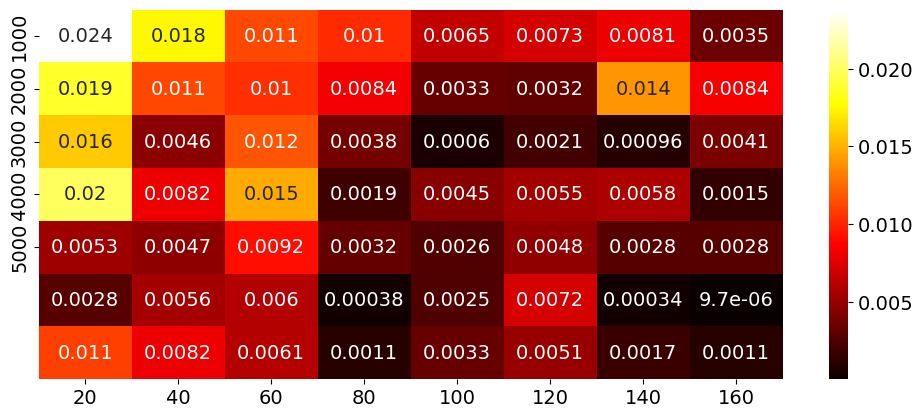

In [117]:
plt.figure(figsize=(12,4.8))

sns.heatmap(np.abs(np.array(comp_prob_B)-obs_prob_set), annot=True, cmap='hot',
            yticklabels=sampling_samples_numbers, xticklabels=bin_numbers);

In [118]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for ii, b in enumerate(comp_prob_A):
    row_string = f'{sampling_samples_numbers[ii]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of A = {true_up_prob_set:.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.02993  0.03407  0.04324  0.02655  0.03154  0.03141  0.02331  0.02121  
 2000   0.01884  0.02078  0.01928  0.02244  0.02151  0.02305  0.02117  0.01906  
 3000   0.01825  0.01951  0.01971  0.01929  0.02267  0.02249  0.02360  0.01922  
 4000   0.02278  0.02367  0.02450  0.02325  0.02408  0.02608  0.02457  0.02218  
 5000   0.02210  0.02235  0.02295  0.02181  0.02294  0.02373  0.02347  0.02067  


IndexError: list index out of range

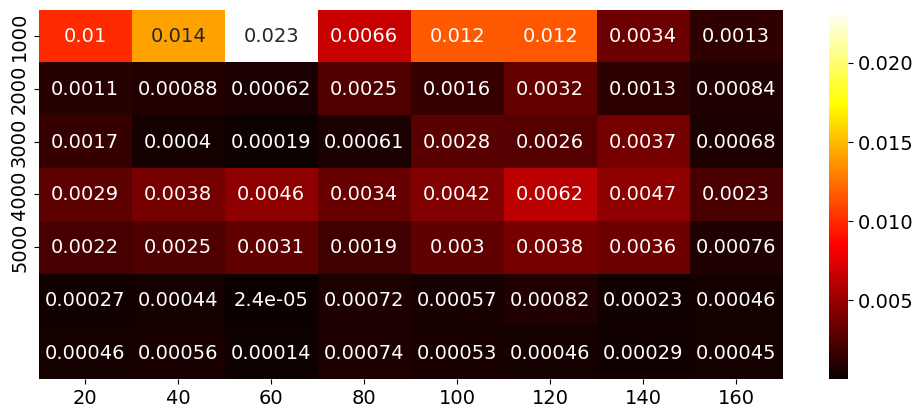

In [119]:
plt.figure(figsize=(12,4.8))

sns.heatmap(np.abs(np.array(comp_prob_A)-true_up_prob_set), annot=True, cmap='hot',
            yticklabels=sampling_samples_numbers, xticklabels=bin_numbers);

NameError: name 'count_A' is not defined

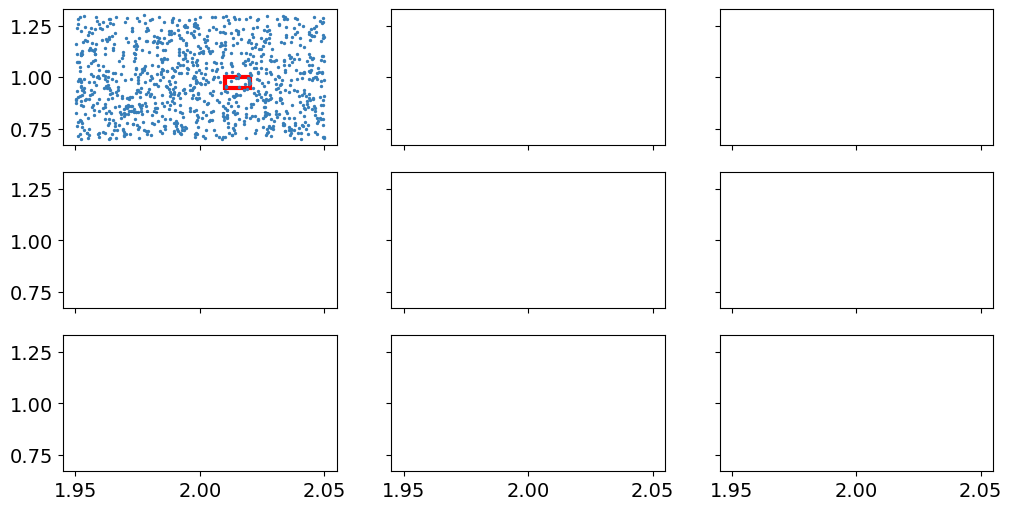

In [120]:
f, axs = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(12,6))

for i in range(3):
    for j in range(3):
        
        n_sampling_samples = sampling_samples_numbers[i * 3 + j]

        set_A = patches.Rectangle((low_x, low_y), upp_x-low_x, upp_y-low_y, color='r', fill=None, linewidth=3)
        axs[i,j].add_patch(set_A)
        axs[i,j].scatter(init_samples[:n_sampling_samples,0], sampling_samples[:n_sampling_samples,1], s=2)
        axs[i,j].set_title(f'Total samples = {n_sampling_samples}, in A = {count_A[i * 3 + j]}', fontsize=12)

# plt.savefig('/Users/kirana/Desktop/work/paper/init_samples_convergence.png')

In [121]:
n_trials = 100
print(sampling_samples_numbers)

[1000, 2000, 3000, 4000, 5000]


In [122]:
low_l = l - delta_l/2
upp_l = l + delta_l/2
low_k = kappa - delta_kappa/2
upp_k = kappa + delta_kappa/2

In [123]:
def init_cdf(x,y):
    return np.min([(x - low_l),0]) * np.min([(y - low_k),0])

In [ ]:
if rerun_distributions == True:

    c_A = []
    c_B = []

    for trial in range(n_trials):
        
        print(f'working on trial {trial}')

        comp_prob_A = []
        comp_prob_B = []

        sampling_samples_full = np.random.normal(0, 1, (sampling_samples_numbers[-1], 2))
        sampling_samples_full[:,1] = np.random.beta(2, 5, (sampling_samples_numbers[-1])) * 2 + 0.5
        sampling_samples_full[:,0] = sampling_samples_full[:,0] * delta_l + l

        # plt.scatter(sampling_samples_full[:,0],sampling_samples_full[:,1])
        # plt.scatter(init_samples[:,0], init_samples[:,1])

        # which_outside = ((sampling_samples_full[:,0] < 1.94) | (sampling_samples_full[:,0] > 2.06))
        # plt.scatter(sampling_samples_full[which_outside,0],sampling_samples_full[which_outside,1])
        
        which_outside = ((sampling_samples_full[:,0] < 1.94) | (sampling_samples_full[:,0] > 2.06)
                         | (sampling_samples_full[:,1] < 0.7) | (sampling_samples_full[:,1] > 1.3))
        n_outside = np.sum(which_outside)
        # print(n_outside)

        while n_outside > 0:
            # print(f'  n_outside = {n_outside}')
            sampling_samples_full[which_outside,:] = np.random.normal(0, 1, (n_outside, 2))
            sampling_samples_full[which_outside,1] = np.random.beta(2, 5, (n_outside)) * 2 + 0.5
            sampling_samples_full[which_outside,0] = sampling_samples_full[which_outside,0] * delta_l + l

            which_outside = ((sampling_samples_full[:,0] < 1.94) | (sampling_samples_full[:,0] > 2.06)
                             | (sampling_samples_full[:,1] < 0.7) | (sampling_samples_full[:,1] > 1.3))
            n_outside = np.sum(which_outside)
    
        pred_samples_full = np.zeros((sampling_samples_numbers[-1], 1))
        pred_samples_full[:, 0] = u(N, sensor_loc, t,
                                    sampling_samples_full[:,0], sampling_samples_full[:,1])

        for i, n_sampling_samples in enumerate(sampling_samples_numbers):

            print(f'nsamples = {n_sampling_samples}')

            comp_prob_A.append([])
            comp_prob_B.append([])

            sampling_samples = sampling_samples_full[:n_sampling_samples,:]

            pred_samples = pred_samples_full[:n_sampling_samples,:]

            for b, n_bins in enumerate(bin_numbers):

                w, bins, centers, w_center = weights.computePartitionedWeights_regulargrid_nonIID(sampling_samples,
                                                                        pred_samples,
                                                                        init_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

                weight_set = 0
                for count, psamp in enumerate(pred_samples): 
                    if psamp >= low_B and psamp <= upp_B:
                        weight_set += w[count]

                up_prob_set = 0
                for count, isamp in enumerate(sampling_samples):
                    if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                        up_prob_set += w[count]

                comp_prob_B[i].append(weight_set)
                comp_prob_A[i].append(up_prob_set)

        c_A.append(comp_prob_A)
        c_B.append(comp_prob_B)

    dist_prob_A = np.array(c_A)
    dist_prob_B = np.array(c_B)

    np.save('./data/convergence_sampling2_prob_A.npy', dist_prob_A.reshape(n_trials, -1))
    np.save('./data/convergence_sampling2_prob_B.npy', dist_prob_B.reshape(n_trials, -1))
    
else:

    dist_prob_A = np.load('./data/convergence_sampling_prob_A.npy').reshape(n_trials,
                                                                        len(sampling_samples_numbers),
                                                                        len(bin_numbers))
    dist_prob_B = np.load('./data/convergence_sampling_prob_B.npy').reshape(n_trials,
                                                                        len(sampling_samples_numbers),
                                                                        len(bin_numbers))

working on trial 0
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 1
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 2
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 3
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 4
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 5
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 6
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 7
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 8
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on trial 9
nsamples = 1000
nsamples = 2000
nsamples = 3000
nsamples = 4000
nsamples = 5000
working on

In [ ]:
print(np.sum(w))

In [106]:
ccc_A = np.mean(c_A, axis=0)
ccc_B = np.mean(c_B, axis=0)

## ccc_A = np.mean(c_A, axis=0)
ccc_B = np.mean(c_B, axis=0)

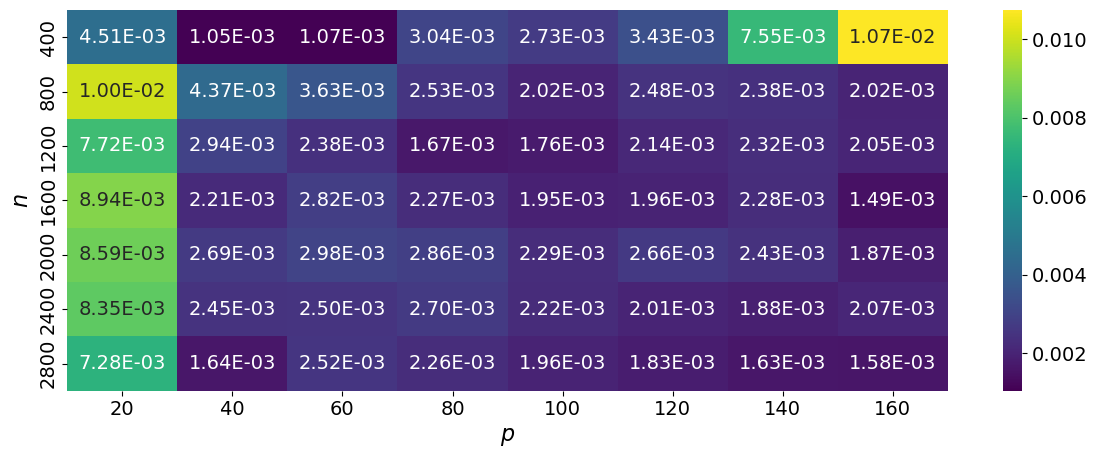

In [107]:
plt.figure(figsize=(12,4.8))

s = sns.heatmap(np.abs(np.array(ccc_B)-obs_prob_set), annot=True, cmap='viridis', fmt='0.2E',
            yticklabels=sampling_samples_numbers, xticklabels=bin_numbers);

s.set_xlabel(r'$p$')
s.set_ylabel(r'$n$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/sampling2_heatmap_meanB.png', bbox_inches='tight')

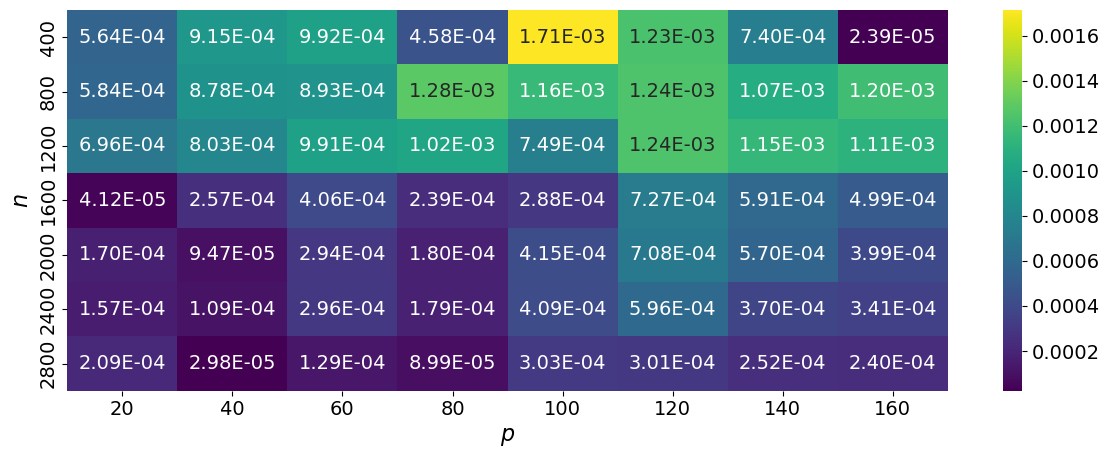

In [108]:
plt.figure(figsize=(12,4.8))

# s = sns.heatmap(np.abs(np.array(ccc_A)-true_up_prob_set), annot=True, cmap='viridis', fmt='0.2E',
#                 yticklabels=init_samples_numbers, xticklabels=bin_numbers);

s = sns.heatmap(np.abs(np.array(ccc_A)-true_up_prob_set), annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=sampling_samples_numbers, xticklabels=bin_numbers);

s.set_xlabel(r'$p$')
s.set_ylabel(r'$n$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/sampling2_heatmap_meanA.png', bbox_inches='tight')

In [109]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for ii, b in enumerate(ccc_A):
    row_string = f'{sampling_samples_numbers[ii]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of A = {true_up_prob_set:.5f}')

             20       40       60       80      100      120      140      160  
  400   0.02047  0.02082  0.02089  0.02036  0.02161  0.02113  0.02064  0.01993  
  800   0.02049  0.02078  0.02079  0.02118  0.02106  0.02114  0.02097  0.02110  
 1200   0.02060  0.02070  0.02089  0.02092  0.02065  0.02114  0.02105  0.02101  
 1600   0.01986  0.02016  0.02031  0.02014  0.02019  0.02063  0.02049  0.02040  
 2000   0.01973  0.02000  0.02020  0.02008  0.02032  0.02061  0.02047  0.02030  
 2400   0.01975  0.02001  0.02020  0.02008  0.02031  0.02050  0.02027  0.02024  
 2800   0.01969  0.01993  0.02003  0.01999  0.02020  0.02020  0.02015  0.02014  

actual probability of A = 0.01990


In [110]:
cccc_A = np.std(c_A, axis=0)
cccc_B = np.std(c_B, axis=0)

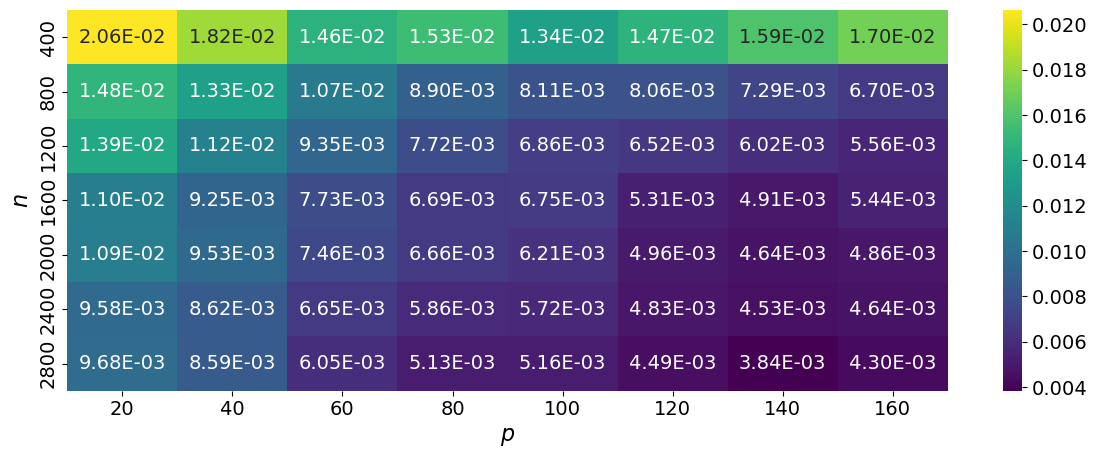

In [111]:
plt.figure(figsize=(12,4.8))

s = sns.heatmap(np.abs(np.array(cccc_B)), annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=sampling_samples_numbers, xticklabels=bin_numbers);

s.set_xlabel(r'$p$')
s.set_ylabel(r'$n$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/sampling2_heatmap_stdB.png', bbox_inches='tight')

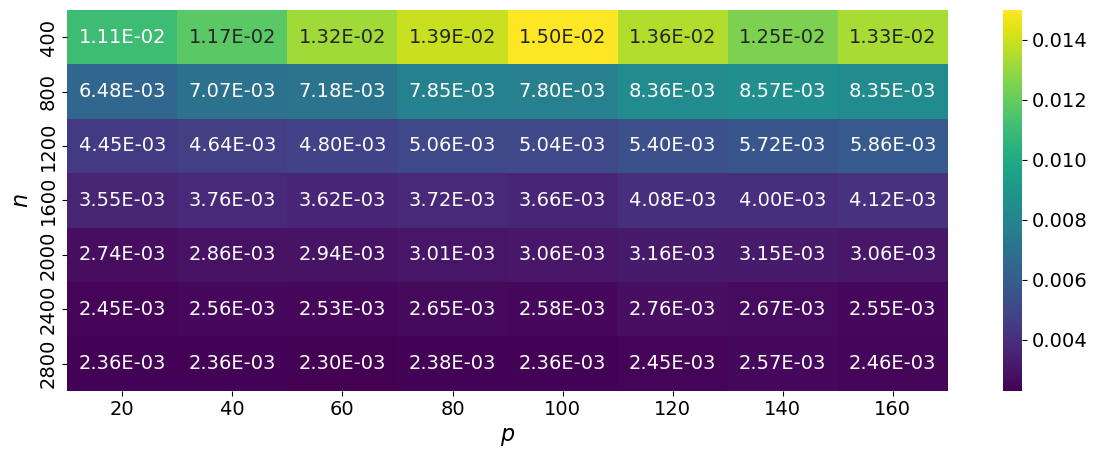

In [112]:
plt.figure(figsize=(12,4.8))

s = sns.heatmap(np.abs(np.array(cccc_A)), annot=True, cmap='viridis', fmt='0.2E',
                yticklabels=sampling_samples_numbers, xticklabels=bin_numbers);
s.set_xlabel(r'$p$')
s.set_ylabel(r'$n$')

plt.tight_layout()
plt.savefig(f'/Users/kirana/Desktop/work/thesis/figures/sampling2_heatmap_stdA.png', bbox_inches='tight')